Imports

In [1]:
import pathlib
import os
import numpy as np
import torch
from torch import optim
from subgraph_matching_via_nn.data.data_loaders import load_graph
from powerful_gnns.util import S2VGraph
from powerful_gnns.util import load_data_given_graph_list_and_label_map
from powerful_gnns.models.graphcnn import GraphCNN
from powerful_gnns.util import separate_data
from powerful_gnns.classifier_training import train, test
from common.EmbeddingCalculationsService import pairwise_l2_distance, show_distance_matrix, \
    calculate_energy_based_hidden_rep
from subgraph_matching_via_nn.training.PairSampleInfo import Pair_Sample_Info
from subgraph_matching_via_nn.data.annotated_graph import AnnotatedGraph
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import MLPGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.embedding_metric_nn import EmbeddingMetricNetwork
from subgraph_matching_via_nn.graph_embedding_networks.gnn_embedding_network import GNNEmbeddingNetwork
from subgraph_matching_via_nn.training.trainer.S2VGraphEmbeddingSimilarityMetricTrainer import \
    S2VGraphEmbeddingSimilarityMetricTrainer
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import SingleEmbeddingGraphMetricNetwork
from subgraph_matching_via_nn.graph_metric_networks.graph_metric_nn import S2VGraphEmbeddingGraphMetricNetwork


In [2]:
goal_subcircuit_name = 'alu'
DATA_PATH = 'C:/Users/kogan/OneDrive/Desktop/Research/AMIT/GraphMatching/subgraph_matching_via_nn/data/subcircuits/'
desktop = pathlib.Path(DATA_PATH)
subgraphs = []
labels = []
for circuit_dir in desktop.iterdir():
    if circuit_dir.is_dir():
        for subcircuit_file in circuit_dir.iterdir():
            if subcircuit_file.is_file():
                file_name = subcircuit_file.name
                if file_name == 'full_graph.p':
                    file_rel_path = f"{os.sep}{file_name}"
                    loader_params = {
                     'data_path' : str(circuit_dir),
                     'g_full_path': file_rel_path,
                     'g_sub_path': file_rel_path}

                    sub_graph = \
                        load_graph(type='subcircuit',
                                   loader_params=loader_params)

                    if goal_subcircuit_name in circuit_dir.name:
                        labels.append(1)
                    else:
                        # continue #TODO?
                        labels.append(0)
                    subgraphs.append(sub_graph)

labels = np.array(labels, dtype='float32')
N = len(subgraphs)
N_training = int(2 / 3 * N)

In [3]:
subgraphs = []
labels = []

circuit_base_dir = 'C:\\Users\\kogan\\OneDrive\\Desktop\\Research\\AMIT\\GraphMatching\\subgraph_matching_via_nn\\data\\subcircuits\\'
for circuit_file_name in ['adder_4', 'alu_4', 'alu_8', 'alu_16', 'alu_32', 'mul_4_4', 'mul_4_8', 'mul_8_8', 'mul_16_16', 'mul_16_32']:
    file_rel_path = 'full_graph.p'
    circuit_dir = f"{circuit_base_dir}{circuit_file_name}{os.sep}"
    loader_params = {
     'data_path' : str(circuit_dir),
     'g_full_path': file_rel_path,
     'g_sub_path': file_rel_path}

    sub_graph = \
        load_graph(type='subcircuit',
                   loader_params=loader_params)
    subgraphs.append(sub_graph)
    labels.append(0)
labels[0] = 1

N = len(subgraphs)
N_training = int(2 / 3 * N)

Transform graphs into S2VGraph-s

In [4]:
g_list = []
label_dict = {}
for subgraph, label in zip(subgraphs, labels):
    g_list.append(S2VGraph(subgraph.G, label))

    if not label in label_dict:
        mapped = len(label_dict)
        label_dict[label] = mapped

Process graph features

In [5]:
graphs, num_classes = load_data_given_graph_list_and_label_map(g_list, label_dict, degree_as_tag=True)

# classes: 2
# maximum node tag: 48
# data: 10


Setup model and training

In [6]:
#set up seeds and gpu device
torch.manual_seed(0)
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

##k-fold cross validation. Conduct an experiment on the fold specified by args.fold_idx.
# train_graphs, test_graphs = separate_data(graphs, seed=0, fold_idx=0, n_splits=1)
# train_graphs = graphs[:4]
# test_graphs = graphs[4:]
train_graphs = test_graphs = graphs

model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=train_graphs[0].node_features.shape[1], hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

Train and Test

In [7]:
from livelossplot import PlotLosses

liveloss = PlotLosses(mode='notebook')

filename = ""
epochs = 3
k_update_plot = 25

for epoch in range(1, epochs + 1):
    scheduler.step()

    avg_loss = train(iters_per_epoch=50, batch_size=len(train_graphs), model=model, device=device, train_graphs=train_graphs, optimizer=optimizer, epoch=epoch)
    acc_train, acc_test = test(model, device, train_graphs, test_graphs, epoch)

    if not filename == "":
        with open(filename, 'w') as f:
            f.write("%f %f %f" % (avg_loss, acc_train, acc_test))
            f.write("\n")
    print("")

    print(model.eps)

    if epoch % k_update_plot == 0:
        liveloss.update({'train error': avg_loss.item()})
        liveloss.send()

c:\users\kogan\.virtualenvs\subcircuit_recognition-mmb-fima\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
epoch: 1: 100%|██████████| 50/50 [00:03<00:00, 13.54batch/s]


loss training: 1.255096
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 2: 100%|██████████| 50/50 [00:02<00:00, 22.14batch/s]


loss training: 0.113457
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


epoch: 3: 100%|██████████| 50/50 [00:02<00:00, 23.26batch/s]


loss training: 0.274114
accuracy train: 1.000000 test: 1.000000

Parameter containing:
tensor([0., 0., 0., 0.], device='cuda:0', requires_grad=True)


Show predictions

In [8]:
pred = model(train_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


In [9]:
pred = model(test_graphs).max(1, keepdim=True)[1]
print(pred)

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0')


show all distances matrix (margin)

In [10]:
all_embeddings = model.get_embedding(graphs)

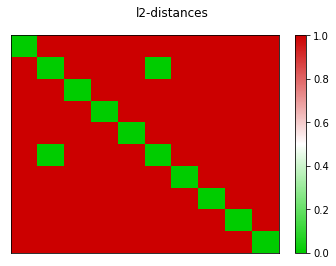

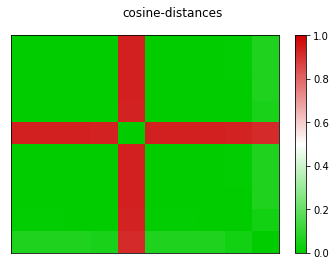

In [11]:
l2_dists = pairwise_l2_distance(all_embeddings)

rounding_constant = 10 ** 3
cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")

what is the smallest margin?

In [12]:
def get_min_non_diagonal_entry(tensor_):
    tensor_with_inf_diag = tensor_ + torch.diag_embed(torch.ones(tensor_.shape[0], device=device) * float("inf"))
    return torch.min(tensor_with_inf_diag).item()

print(get_min_non_diagonal_entry(l2_dists))
print(get_min_non_diagonal_entry(cos_dists))

0.00036881212145090103
0.0


Contrastive loss training

Assemble graph pairs data

In [13]:
train_samples_list = []
reference_subgraph = subgraphs[0]
negative_examples_subgraphs = subgraphs[1:]

for subgraph in subgraphs:
    if subgraph == reference_subgraph:
        is_negative_example = False
    else:
        is_negative_example = True

    G1_annotated = AnnotatedGraph(subgraph.G)
    G2_annotated = AnnotatedGraph(reference_subgraph.G)
    train_samples_list.append(Pair_Sample_Info(
        subgraph=G1_annotated,
        masked_graph=G2_annotated,
        is_negative_sample=torch.tensor(is_negative_example)))

val_samples_list = train_samples_list

Define GNN model

In [18]:
# input dim matches the node mask (w) shape
input_dim = S2VGraphEmbeddingSimilarityMetricTrainer.get_model_expected_input_dim(train_samples_list[0])
model = GraphCNN(num_layers=5, num_mlp_layers = 2, input_dim=input_dim, hidden_dim=64, output_dim=num_classes, final_dropout=0.5, learn_eps=False, graph_pooling_type="sum", neighbor_pooling_type="sum", device=device).to(device)

Define graph metric to train, and the trainer

In [19]:
solver_params = {
    "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "lr": 1e-3, "weight_decay": 1e-3,
    "max_epochs": None,
    "cycle_patience": 5, "step_size_up": 10, "step_size_down": 10,
    "loss_convergence_threshold": None,
    "train_loss_convergence_threshold": 1e-1,
    "successive_convergence_min_iterations_amount": 50,
    "margin_loss_margin_value": 20,
    "max_grad_norm": 0.1,
    "k_update_plot": 5,
    "batch_size": len(subgraphs),
}

problem_params = {"input_dim": input_dim}

dump_base_path = f".{os.sep}runlogs"

loss_fun = torch.nn.MSELoss()
embedding_metric_network = EmbeddingMetricNetwork(loss_fun=loss_fun)

gnn_embedding_nn = GNNEmbeddingNetwork(gnn_model=model)

# embedding_nns = \
#     [
#         GNNEmbeddingNetwork(gnn_model=model),
#     ]

graph_metric_nn = S2VGraphEmbeddingGraphMetricNetwork(embedding_network=gnn_embedding_nn,
                                       embdding_metric_network=embedding_metric_network,
                                       device=device)

# graph_metric_nn = SingleEmbeddingGraphMetricNetwork(embedding_network=embedding_nns[0],
#                                        embdding_metric_network=embedding_metric_network,
#                                        device=device)

# graph_metric_nn = MLPGraphMetricNetwork(embedding_networks=embedding_nns,
#                                         embdding_metric_network=embedding_metric_network,
#                                         device=device)


trainer = S2VGraphEmbeddingSimilarityMetricTrainer(graph_metric_nn, dump_base_path,
                                  problem_params, solver_params)

Train

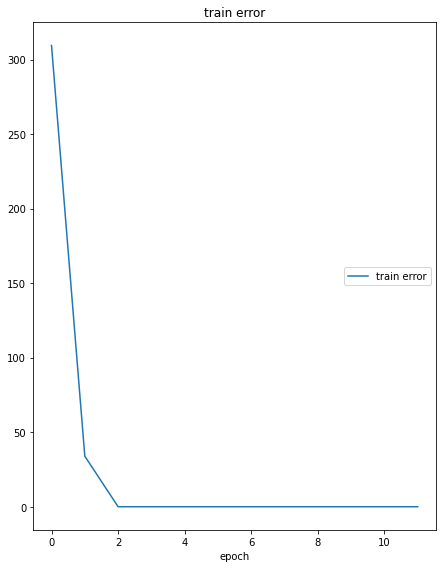

train error
	train error      	 (min:    0.000, max:  309.497, cur:    0.000)


([493.5926818847656,
  493.5926818847656,
  448.559326171875,
  388.40216064453125,
  309.4967346191406,
  236.9344940185547,
  263.90625,
  184.42538452148438,
  69.47718048095703,
  33.96060562133789,
  14.511292457580566,
  12.45765495300293,
  1.0149743556976318,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  0.03539545089006424,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.999999717180685e-10,
  9.99999

In [20]:
trainer.train(train_samples_list, val_samples_list)

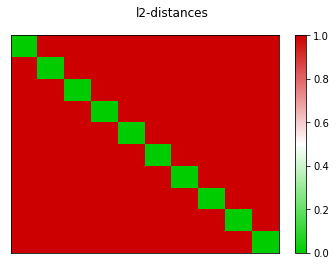

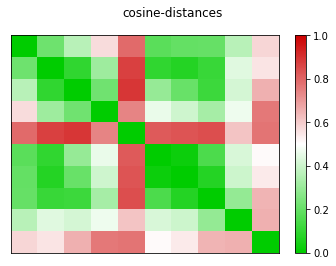

518.2545776367188
0.027000000700354576


In [21]:
all_embeddings = model.get_embedding(graphs)

l2_dists = pairwise_l2_distance(all_embeddings)

rounding_constant = 10 ** 3
cos_dists = torch.round(calculate_energy_based_hidden_rep(all_embeddings, threshold=-1) * rounding_constant) / rounding_constant

show_distance_matrix(l2_dists, "l2-distances")
show_distance_matrix(cos_dists, "cosine-distances")
print(get_min_non_diagonal_entry(l2_dists))
print(get_min_non_diagonal_entry(cos_dists))